In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import pickle

In [8]:
data = pd.read_csv("Msg.csv")
data.head()

,Message,Type
0,Rs.400.00 credited to a/c *1234 on 06/06/2024 ...,Transaction
1,A/c *4354 debited Rs. 10000.00 on 13-06-24 to ...,Transaction
2,Rs.12100.00 credited to a/c *8984 on 29/05/202...,Transaction
3,Rs.100.00 credited to a/c *4244 on 08/05/2024 ...,Transaction
4,Qwerty has requested money from you on PhonePe...,Transaction


In [9]:
data.columns

Index(['Message', 'Type'], dtype='object')

In [10]:
data['Type'].unique

<bound method Series.unique of 0     Transaction
1     Transaction
2     Transaction
3     Transaction
4     Transaction
         ...     
62     Bank Promo
63     Bank Promo
64     Bank Promo
65     Bank Promo
66     Bank Promo
Name: Type, Length: 67, dtype: object>

In [11]:
mod_data = pd.get_dummies(data, columns = ['Type'], dtype=int)
mod_data

,Message,Type_Bank Promo,Type_Transaction
0,Rs.400.00 credited to a/c *1234 on 06/06/2024 ...,0,1
1,A/c *4354 debited Rs. 10000.00 on 13-06-24 to ...,0,1
2,Rs.12100.00 credited to a/c *8984 on 29/05/202...,0,1
3,Rs.100.00 credited to a/c *4244 on 08/05/2024 ...,0,1
4,Qwerty has requested money from you on PhonePe...,0,1
...,...,...,...
62,Short on funds? Get Rs475000 Loan on your HDFC...,1,0
63,Avail instant disbursement with HDFC Bank Rs. ...,1,0
64,Hi In need of instant cash? Rs.600000 @0.99% ...,1,0
65,Dear Easy steps to cash: HDFC Bank Personal Lo...,1,0


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [14]:
X = mod_data['Message']
y = mod_data[mod_data.columns[1:]].values

In [15]:
MAX_FEATURES = 200000 
# number of words in the vocab
# drop this number if Ram usage is more

In [16]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [17]:
vectorizer.adapt(X.values)

In [28]:
# Pickle the config and weights
pickle.dump({'config': vectorizer.get_config(),
             'weights': vectorizer.get_weights()}
            , open("tv_layer.pkl", "wb"))

In [60]:
from_disk = pickle.load(open("tv_layer.pkl", "rb"))
new_v = TextVectorization.from_config(from_disk['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
new_v.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
new_v.set_weights(from_disk['weights'])

# Lets see the Vector for word "this"
print (new_v("this"))

tf.Tensor([1 0 0 ... 0 0 0], shape=(1800,), dtype=int64)


In [18]:
vectorized_text = vectorizer(X.values)

In [19]:
vectorized_text

<tf.Tensor: shape=(67, 1800), dtype=int64, numpy=
array([[ 72,  30,   2, ...,   0,   0,   0],
       [  5, 272,  36, ...,   0,   0,   0],
       [107,  30,   2, ...,   0,   0,   0],
       ...,
       [ 87,  86, 209, ...,   0,   0,   0],
       [ 65, 249, 175, ...,   0,   0,   0],
       [219, 205, 146, ...,   0,   0,   0]], dtype=int64)>

In [20]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps prevent bottlenecks

In [21]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [22]:
batch_y.shape

(16, 2)

In [35]:
len(dataset)

5

In [23]:
train_size = max(int(len(dataset) * 0.7), 1)
val_size = max(int(len(dataset) * 0.2), 1)
test_size = max(int(len(dataset) * 0.1), 1)

train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size + val_size).take(test_size)

In [37]:
print(val_size)

1


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [25]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(2, activation='sigmoid'))

In [26]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                        

In [43]:
pickle.dump(model, open('model.pkl', 'wb'))

In [28]:
# Define the EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

history = model.fit(train, epochs=12, validation_data=val, shuffle=True, callbacks=[early_stopping])

Epoch 1/12
3/3 [==============================] - 24s 3s/step - loss: 0.6898 - val_loss: 0.6832
Epoch 2/12
3/3 [==============================] - 5s 2s/step - loss: 0.6767 - val_loss: 0.7084
Epoch 3/12
3/3 [==============================] - 5s 2s/step - loss: 0.6661 - val_loss: 0.5909
Epoch 4/12
3/3 [==============================] - 5s 2s/step - loss: 0.6311 - val_loss: 0.6557
Epoch 5/12
3/3 [==============================] - 5s 2s/step - loss: 0.5992 - val_loss: 0.5340
Epoch 6/12
3/3 [==============================] - 5s 2s/step - loss: 0.5551 - val_loss: 0.4784
Epoch 7/12
3/3 [==============================] - 5s 2s/step - loss: 0.5102 - val_loss: 0.4716
Epoch 8/12
3/3 [==============================] - 5s 2s/step - loss: 0.4730 - val_loss: 0.3177
Epoch 9/12
3/3 [==============================] - 5s 2s/step - loss: 0.3445 - val_loss: 0.2718
Epoch 10/12
3/3 [==============================] - 5s 2s/step - loss: 0.2544 - val_loss: 0.2315
Epoch 11/12
3/3 [==============================]

In [29]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

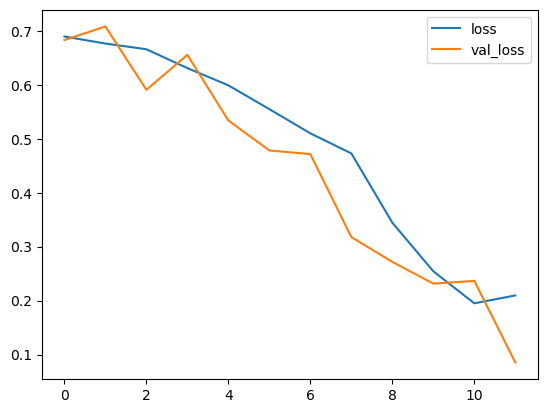

In [30]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [31]:
mod_data.columns[1:]

Index(['Type_Bank Promo', 'Type_Transaction'], dtype='object')

In [32]:

input_text = vectorizer('A/c *1478 debited Rs. 500.00 on 05-07-24 to Corporation. Not you? SMS BLOCK to 9231000001 Dial 1930 for Cyber Fraud')

In [33]:
print(np.shape(np.expand_dims(input_text,0)))

(1, 1800)


In [34]:
output = model.predict(np.expand_dims(input_text,0))
# Format the output array to remove scientific notation
formatted_output = np.array2string(output, formatter={'float_kind': lambda x: "%.8f" % x})

print(formatted_output)

1/1 [==============================] - 3s 3s/step
[[0.00371334 0.98056531]]


In [88]:
ex = ["A/c *1478 debited Rs. 500.00 on 05-07-24 to Corporation. Not you? SMS BLOCK to 9231000001 Dial 1930 for Cyber Fraud"]
from_disk = pickle.load(open("tv_layer.pkl", "rb"))
new_v = TextVectorization.from_config(from_disk['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
new_v.adapt(tf.data.Dataset.from_tensor_slices(["xyzjhuygtf"]))
new_v.set_weights(from_disk['weights'])

# Lets see the Vector for word "this"
text = new_v(ex[0])

In [89]:
output = model.predict(np.expand_dims(text,0))
# Format the output array to remove scientific notation
formatted_output = np.array(output)

print(np.max(formatted_output))

1/1 [==============================] - 0s 436ms/step
0.5022285


In [78]:
batch = test.as_numpy_iterator().next()

In [51]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [52]:
batch_y

array([[0, 1],
       [1, 0],
       [0, 0]])

In [53]:
(model.predict(batch_X)>0.5).astype(int)

1/1 [==============================] - 0s 382ms/step


array([[0, 1],
       [1, 0],
       [0, 1]])

In [54]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [55]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [56]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 354ms/step


In [57]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 1.0, Recall:1.0, Accuracy:1.0
